In [50]:
!pip install folium

from project_lib import Project
import numpy as np
import pandas as pd
import requests
import datetime
from pandas.io.json import json_normalize, json
import folium
import matplotlib.pyplot as plt 
from sklearn import preprocessing

In [2]:
# The code was removed by Watson Studio for sharing.

In [22]:
header_column_list = ['astronomy', 'avgtempC', 'avgtempF', 'date', 'hourly', 'maxtempC', 'maxtempF', 'mintempC', 'mintempF', 'sunHour', 'totalSnow_cm', 'uvIndex']
df_result_nyc = pd.DataFrame(columns=header_column_list)
df_result_tokyo = pd.DataFrame(columns=header_column_list)
    
start_date = datetime.date(2012, 4, 1)
end_date = datetime.date(2013, 2, 20)
from_date = start_date
    
while from_date < end_date:
    to_date = from_date + datetime.timedelta(days=31)
    #print(str(previous) + ' - ' + str(date))
    #print('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=ec64962692ca48399ce223327201804&q=New York&format=json&date={start_date}&enddate={end_date}&tp=1'.format(start_date=str(previous), end_date=str(date)))
    result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={key}&q=New York&format=json&extra=utcDateTime&date={from_date}&enddate={to_date}&tp=1'.format(key= weatheronline_api_key, from_date=str(from_date), to_date=str(to_date)))
    df_result_nyc = df_result_nyc.append(pd.DataFrame(result.json()['data']['weather']))
    result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={key}&q=Tokyo&format=json&extra=utcDateTime&date={from_date}&enddate={to_date}&tp=1'.format(key= weatheronline_api_key, from_date=str(from_date), to_date=str(to_date)))
    df_result_tokyo = df_result_tokyo.append(pd.DataFrame(result.json()['data']['weather']))
    from_date = to_date + datetime.timedelta(days=1)
project.save_data("weather_nyc.csv", df_result_nyc.to_csv(index=False), overwrite=True)
project.save_data("weather_tokyo.csv", df_result_tokyo.to_csv(index=False), overwrite=True)

{'file_name': 'weather_tokyo.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'courseracapstone-donotdelete-pr-7t0f3lec5wk16g',
 'asset_id': '3505d64f-5cba-4be2-b188-994d310ba4d1'}

In [3]:
df_nyc = pd.read_csv(project.get_file('dataset_TSMC2014_NYC.csv'))
df_tokyo = pd.read_csv(project.get_file('dataset_TSMC2014_TKY.csv'))

df_nyc_weather = pd.read_csv(project.get_file('weather_nyc.csv'))
df_tokyo_weather = pd.read_csv(project.get_file('weather_tokyo.csv'))

df_nyc_weather['hourly'] = df_nyc_weather['hourly'].str.replace("'", '"')


In [4]:
df_nyc_weather_hourly_all = pd.DataFrame()
for index, row in df_nyc_weather.iterrows():
    #df_nyc_weather['hourly'][index]
    df_nyc_weather_hourly = json.loads(row['hourly'])
    df_nyc_weather_hourly = pd.DataFrame(df_nyc_weather_hourly)
    df_nyc_weather_hourly['sunHour'] = row['sunHour']
    df_nyc_weather_hourly_all = df_nyc_weather_hourly_all.append(df_nyc_weather_hourly, ignore_index = True)

In [5]:
list_drop_columns = ['DewPointC', 'DewPointF', 'FeelsLikeC', 'FeelsLikeF', 'HeatIndexC', 'HeatIndexF', 'WindChillC', 'WindChillF', 'uvIndex', 'visibility', 'visibilityMiles', 'WindGustKmph',
                     'WindGustMiles', 'visibility', 'visibilityMiles', 'weatherCode', 'weatherDesc', 'weatherIconUrl', 'winddir16Point', 'winddirDegree', 'windspeedKmph', 'windspeedMiles',
                     'precipInches', 'pressureInches', 'tempF', 'time']
df_nyc_weather_hourly_all.drop(columns=list_drop_columns, inplace=True)


In [6]:
replace_from_list = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']
replace_to_list = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
df_nyc_weather_hourly_all['UTCtime'] = df_nyc_weather_hourly_all['UTCtime'].replace(replace_from_list, replace_to_list)

In [7]:
df_nyc_weather_hourly_all['timestamp'] = pd.to_datetime(df_nyc_weather_hourly_all['UTCdate'] + " " + df_nyc_weather_hourly_all['UTCtime'])
df_nyc['timestamp'] = pd.to_datetime(df_nyc['utcTimestamp'], format='%a %b %d %X %z %Y').dt.tz_localize(None).dt.round('H')
df_nyc_w_weather = df_nyc.merge(df_nyc_weather_hourly_all, how='inner', on=['timestamp'])

In [16]:
df_nyc_w_weather['timestamp_loc'] = df_nyc_w_weather['timestamp'] + datetime.timedelta(hours=-4)

# Explore Data

In [17]:
df_nyc_w_weather.groupby(by=['venueCategory'])['userId'].count().sort_values(ascending=False).head(10)

venueCategory
Bar                     15555
Home (private)          14787
Office                  12336
Subway                   9048
Gym / Fitness Center     8882
Coffee Shop              7228
Food & Drink Shop        6340
Train Station            6164
Park                     4601
Neighborhood             4453
Name: userId, dtype: int64

In [18]:
df_nyc_w_weather.groupby(by=['venueCategory']).agg({'venueId': pd.Series.nunique}).sort_values(by='venueId', ascending=False).head(10)

,venueId
venueCategory,
Bar,2470
Office,1323
Home (private),1254
Food & Drink Shop,1182
Bus Station,1036
Clothing Store,987
Medical Center,857
Coffee Shop,842
Pizza Place,827


In [19]:
df_nyc_w_weather.groupby(by=['venueCategory'])['userId'].count().sort_values(ascending=True).head(10)

venueCategory
Music School              1
Motorcycle Shop           2
Photography Lab           2
Sorority House            2
Castle                    2
Pet Service               3
Afghan Restaurant         4
Gluten-free Restaurant    5
Internet Cafe             6
Portuguese Restaurant     7
Name: userId, dtype: int64

In [20]:
df_nyc_w_weather.groupby(by=['venueCategory']).agg({'venueId': pd.Series.nunique}).sort_values(by='venueId', ascending=True).head(10)

,venueId
venueCategory,
Sorority House,1
Motorcycle Shop,1
Music School,1
Castle,1
Swiss Restaurant,1
Aquarium,2
Photography Lab,2
Internet Cafe,3
Market,3


In [21]:
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for index, location in df_nyc_w_weather[['longitude', 'latitude', 'venueCategory']].drop_duplicates().iterrows():
    if location['venueCategory'] == 'Zoo':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='blue')
        ).add_to(nyc_map)
    elif location['venueCategory'] == 'Airport':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='red')
        ).add_to(nyc_map)
    elif location['venueCategory'] == 'Temple':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='green')
        ).add_to(nyc_map)
nyc_map

# Segment Data with K-Mode

In [77]:
df_nyc_w_weather['season_bin'] = pd.cut(df_nyc_w_weather['timestamp_loc'].dt.month, bins=[1, 2, 5, 8, 11, 12], labels=['winter_1', 'spring', 'summer', 'autumn', 'winter_2'], include_lowest =True)
df_nyc_w_weather['season_bin'] = df_nyc_w_weather['season_bin'].replace(['winter_1', 'winter_2'], ['winter', 'winter'])

df_nyc_w_weather['day_bin'] = pd.cut(df_nyc_w_weather['timestamp_loc'].dt.hour, bins=[0, 5, 10, 12, 16, 20, 23], labels=['night_1', 'morning', 'noon', 'afternoon', 'evening', 'night_2'], include_lowest =True)
df_nyc_w_weather['day_bin'] = df_nyc_w_weather['day_bin'].replace(['night_1', 'night_2'], ['night', 'night'])

df_nyc_w_weather['day_ow_bin'] = df_nyc_w_weather['timestamp_loc'].dt.strftime('%A')

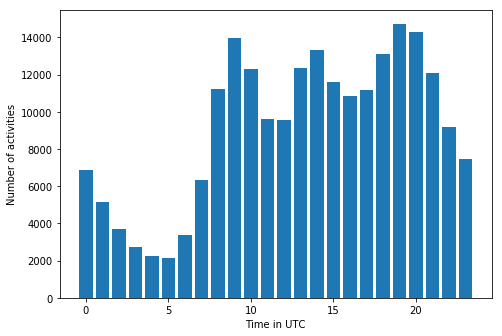

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nyc_w_weather['timestamp_loc'].groupby(df_nyc_w_weather['timestamp_loc'].dt.hour).size().index, df_nyc_w_weather['timestamp_loc'].groupby(df_nyc_w_weather['timestamp_loc'].dt.hour).size())
ax.set_xlabel('Time in UTC')
ax.set_ylabel('Number of activities')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nyc_w_weather.groupby(df_nyc_w_weather['day_ow_bin']).size().index, df_nyc_w_weather['day_ow_bin'].groupby(df_nyc_w_weather['day_ow_bin']).size())
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of activities')
plt.show()

print(df_nyc_w_weather.groupby(df_nyc_w_weather['day_ow_bin']).size())

In [49]:
df_nyc_w_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219501 entries, 0 to 219500
Data columns (total 20 columns):
userId             219501 non-null int64
venueId            219501 non-null object
venueCategoryId    219501 non-null object
venueCategory      219501 non-null object
latitude           219501 non-null float64
longitude          219501 non-null float64
timezoneOffset     219501 non-null int64
utcTimestamp       219501 non-null object
timestamp          219501 non-null datetime64[ns]
UTCdate            219501 non-null object
UTCtime            219501 non-null object
cloudcover         219501 non-null object
humidity           219501 non-null object
precipMM           219501 non-null object
pressure           219501 non-null object
tempC              219501 non-null object
sunHour            219501 non-null float64
season_bin         219501 non-null object
timestamp_loc      219501 non-null datetime64[ns]
day_cat            219501 non-null object
dtypes: datetime64[ns](2), float

In [ ]:
# Validate Date (if time conversion <> hat worked properly and all categories were assigned properly) before removing cols

In [55]:
drop_col_list = ['venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset', 'utcTimestamp', 'timestamp', 'UTCdate', 'UTCtime']
df_nyc_w_weather_ml = df_nyc_w_weather.drop(columns = drop_col_list, axis=1)
df_nyc_w_weather_ml

,userId,venueCategory,cloudcover,humidity,precipMM,pressure,tempC,sunHour,season_bin,timestamp_loc,day_cat
0,718,Subway,33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
1,582,Home (private),33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
2,445,American Restaurant,33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
3,531,Home (private),33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
4,440,Home (private),33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
5,439,Home (private),33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
6,718,Subway,33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
7,601,Pizza Place,33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
8,1,Bar,33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night
9,281,College Academic Building,33,65,0.0,1006,8,11.6,spring,2012-04-10 00:00:00,night


In [ ]:
LE = preprocessing.LabelEncoder()

# Predict